## 理论证明：
一个两层的ReLU（Rectified Linear Unit）网络在理论上可以近似模拟任何有界闭集函数。这是由于ReLU是一种非线性激活函数，可以引入网络的非线性特性，使其具备强大的表示能力。

该结论是基于深度学习中的“万能逼近定理”（Universal Approximation Theorem）而得出的。万能逼近定理表明，一个具有足够数量的隐藏单元的单隐藏层前馈神经网络可以以任意精度逼近任何连续函数。而ReLU网络恰好满足这个条件。


## 函数定义

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math

In [ ]:
def target_func(x):
    """
    计算给定数字的平方。

    参数:
    x (int/float): 需要计算平方的数字。

    返回:
    int/float: x的平方值。
    """
    return x * x

## 数据采集

In [ ]:
# 生成从0到5π的等差数列，步长为0.001，用于后续的函数计算和绘图
x = np.arange(0, 5 * np.pi, 0.001)

# 对x中的每个值应用目标函数target_func，得到对应的y值列表
y = [target_func(i) for i in x]

# 将数据集分为训练集和测试集，测试集比例为20%，使用随机种子1以确保结果的可重复性
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# 进一步将训练集分为训练集和验证集，验证集比例为训练集的12.5%，同样使用随机种子1以确保结果的可重复性
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1)

## 模型描述

In [ ]:
# 定义神经网络各层的维度
input_dim = 1
hidden_dim = 16
output_dim = 1

# 初始化权重矩阵W1，使用正态分布随机数乘以sqrt(1/input_dim)来减小初始权重值
W1 = np.random.randn(hidden_dim, input_dim) * np.sqrt(1 / input_dim)
# 初始化输出层权重矩阵W2，同样使用正态分布随机数乘以sqrt(1/hidden_dim)
W2 = np.random.randn(output_dim, hidden_dim) * np.sqrt(1 / hidden_dim)
# 初始化隐藏层偏置向量b1，所有元素为0
b1 = np.zeros((hidden_dim, 1))
# 初始化输出层偏置向量b2，所有元素为0
b2 = np.zeros((output_dim, 1))

In [ ]:
# Cache dictionary for storing intermediate results during forward and backward propagation
cache = {}

# Define the linear transformation function
def Linear(W, X, b):
    """
    Perform linear transformation on input X using weight W and bias b.
    
    Parameters:
    W: Weight matrix
    X: Input matrix
    b: Bias vector
    
    Returns:
    Result of linear transformation
    """
    return np.matmul(W, X) + b

# Define the ReLU activation function
def relu(X):
    """
    Apply ReLU activation function on input X.
    
    Parameters:
    X: Input matrix
    
    Returns:
    Result after applying ReLU activation function
    """
    return np.where(X > 0, X, 0)

# Define the forward propagation function
def forward(x):
    """
    Perform forward propagation on input x.
    
    Parameters:
    x: Input vector
    
    Returns:
    Output vector after forward propagation
    """
    # Store the input of the first layer
    cache['out0'] = x
    # First layer linear transformation
    x = Linear(W1, x, b1)
    cache['out1'] = x
    # Apply ReLU activation function after first layer
    x = relu(x)
    cache['out2'] = x
    # Second layer linear transformation
    output = Linear(W2, x, b2)
    cache['out3'] = output
    return output

# Define the loss function
def loss_fn(y_pred, target):
    """
    Calculate the loss between predicted value y_pred and target value target.
    
    Parameters:
    y_pred: Predicted value
    target: Target value
    
    Returns:
    Calculated loss value
    """
    # Calculate the mean squared error loss
    loss = np.sum((y_pred - target) * (y_pred - target), axis=1, keepdims=True) / len(y_pred)
    # Calculate the gradient of the loss function
    cache['loss'] = (y_pred - target) / len(y_pred)
    return loss

# Define the backward propagation function
def backward(lr, batch_size):
    """
    Perform backward propagation and update weights and biases.
    
    Parameters:
    lr: Learning rate
    batch_size: Batch size
    """
    global W1, W2, b1, b2

    # Calculate the error of the second layer
    delta2 = 1 / batch_size * cache['loss']
    # Calculate the gradient of the weight of the second layer
    dW2 = 1 / batch_size * np.matmul(delta2, cache['out2'].T)
    # Calculate the gradient of the bias of the second layer
    db2 = 1 / batch_size * np.sum(delta2, axis=1, keepdims=True)

    # Calculate the error of the first layer
    delta1 = np.matmul(W2.T, delta2) * np.where(cache['out1'] > 0, 1, 0)
    # Calculate the gradient of the weight of the first layer
    dW1 = 1 / batch_size * np.matmul(delta1, cache['out0'].T)
    # Calculate the gradient of the bias of the first layer
    db1 = 1 / batch_size * np.sum(delta1, axis=1, keepdims=True)

    # Update weights and biases of the first and second layers
    W1 -= lr * dW1
    W2 -= lr * dW2
    b1 -= lr * db1
    b2 -= lr * db2

In [ ]:
def predict(ranger):
    """
    Evaluation function
    Args:
        ranger: List, 2 elements for start number and end number
    """
    # Initialize lists to store input values and corresponding predictions
    x_plot = []
    y_pred = []
    
    # Iterate through the specified range to calculate predictions
    for i in range(ranger[0], ranger[1]):
        # Perform the first layer linear transformation
        x = Linear(W1, np.array([[i]]), b1)
        # Apply ReLU activation function
        x = relu(x)
        # Perform the second layer linear transformation
        output = Linear(W2, x, b2)
        # Store the input value
        x_plot.append(i)
        # Store the prediction
        y_pred.extend(output)

    # Plot the ground truth curve
    plt.plot(x_plot, [target_func(i) for i in x_plot])
    # Plot the prediction curve
    plt.plot(x_plot, y_pred)
    # Add legend annotations
    plt.legend(["Ground truth", "Prediction"])

In [7]:
def train(X, y, epochs=5, batch_size=10, lr=0.001, verbose_ep=100):
    """
    Training funcition
    Args:
        X: input dataset
        y: target label
        batch_size: batch size
        lr: learning rate
        verbose_ep: display loss per verbose_ep epoch
    """
    for epoch in tqdm(range(epochs)):
        rec_loss = 0
        for batch_idx in range(len(X) // batch_size):
            X_batched = np.array([X[batch_idx * batch_size: min((batch_idx + 1) * batch_size, len(X))]])
            y_batched = np.array([y[batch_idx * batch_size: min((batch_idx + 1) * batch_size, len(X))]])
            y_pred = forward(X_batched)
            loss = np.sum(loss_fn(y_pred,np.array(y_batched))) / len(y_pred)
            rec_loss += loss
            backward(lr, batch_size)
        if epoch % verbose_ep == 0:
            print(f"Epoch:{epoch}, Loss:{rec_loss / (len(X) // batch_size)}")

In [8]:
train(X_train, y_train, epochs=5000, batch_size=32, lr=0.01, verbose_ep=1000)

  0%|          | 9/5000 [00:00<01:59, 41.65it/s]

Epoch:0, Loss:23417.53495944138


 20%|██        | 1006/5000 [00:25<01:34, 42.37it/s]

Epoch:1000, Loss:16.46651174905025


 40%|████      | 2007/5000 [00:52<01:10, 42.20it/s]

Epoch:2000, Loss:11.709865395203417


 60%|██████    | 3004/5000 [01:17<01:01, 32.53it/s]

Epoch:3000, Loss:8.82240153433885


 80%|████████  | 4003/5000 [01:43<00:26, 37.71it/s]

Epoch:4000, Loss:8.291376350087708


100%|██████████| 5000/5000 [02:08<00:00, 38.91it/s]


## 拟合效果

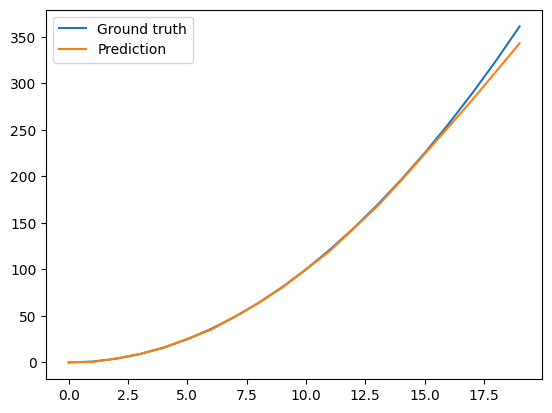

In [9]:
predict([0, 20])